# 05 面向对象的有限元编程

In [1]:
import numpy as np
import pygmsh
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
        ],
        mesh_size=0.5,
    )
    mesh = geom.generate_mesh()

In [3]:
class Constitutive:
    def __init__(self,E,nv):
        self.E=E 
        self.nv=nv 
        self.D=self.cal_D()
        self.tangent=self.cal_tangent()

    def cal_D(self):
        E=self.E
        nv=self.nv
        return E/(1.0-nv**2)*np.array([
            [1.0,nv,0.0], 
            [nv,1.0,0.0], 
            [0.0,0.0,0.5*(1.0-nv)]])
    
    def cal_tangent(self):
        return self.D
    
    def get_stress(self,strain):
        return self.D@strain

In [4]:
material_0=Constitutive(10.0,0.3)
material_1=Constitutive(100.0,0.3)
material_0.D

array([[10.98901099,  3.2967033 ,  0.        ],
       [ 3.2967033 , 10.98901099,  0.        ],
       [ 0.        ,  0.        ,  3.84615385]])

In [5]:
class Element:
    """plane triangle element"""
    def __init__(self,material,positions):
        """postion=ndarray([[x0,y0],[x1,y1],[x2,y2]])"""
        self.x=positions.T[0]
        self.y=positions.T[1]
        self.node_set=np.array([0,1,2],dtype=np.uint64)
        self.D=material.D
        self.area_2=self.cal_area_2()
        self.B=self.cal_B()
        self.K_element=self.element_integrate()

    def cal_area_2(self):
        x=self.x
        y=self.y
        matrix=np.array([
            [1.0,x[0],y[0]], 
            [1.0,x[1],y[1]], 
            [1.0,x[2],y[2]]])
        det=np.linalg.det(matrix)
        return abs(det)
    
    def cal_B(self):
        x=self.x
        y=self.y
        return 0.5/self.area_2*np.array([
            [y[1]-y[2],0.0,y[2]-y[0],0.0,y[0]-y[1],0.0], 
            [0.0,x[2]-x[1],0.0,x[0]-x[2],0.0,x[1]-x[0]], 
            [x[2]-x[1],y[1]-y[2],x[0]-x[2],y[2]-y[0],x[1]-x[0],y[0]-y[1]]])
    
    def element_integrate(self):
        return self.area_2*self.B.T@self.D@self.B
    
    def set_node_set(self,node_set):
        self.node_set=node_set
    
    def get_strain(self,deform_local):
        return self.B@deform_local

    def get_stress(self,deform_local):
        return self.D@self.B@deform_local

In [6]:
position=np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0]])
element=Element(material_0,position)
element.K_element

array([[ 3.70879121,  1.78571429, -0.96153846, -0.82417582, -2.74725275,
        -0.96153846],
       [ 1.78571429,  3.70879121, -0.96153846, -2.74725275, -0.82417582,
        -0.96153846],
       [-0.96153846, -0.96153846,  0.96153846,  0.        ,  0.        ,
         0.96153846],
       [-0.82417582, -2.74725275,  0.        ,  2.74725275,  0.82417582,
         0.        ],
       [-2.74725275, -0.82417582,  0.        ,  0.82417582,  2.74725275,
         0.        ],
       [-0.96153846, -0.96153846,  0.96153846,  0.        ,  0.        ,
         0.96153846]])

In [7]:
class GlobalStiffness:
    def __init__(self,mesh):
        # get mesh data
        self.nodes=mesh.points[:,:2]
        self.elements=mesh.cells_dict['triangle']
        self.meterials=mesh.cell_data
        # initial global variables
        self.len_global=2*len(self.nodes)
        self.deform=np.zeros(self.len_global)
        self.force=np.zeros(self.len_global)
        self.cal_K()
    
    def instant_Element(self,element_index,node_set):
        material=self.meterials[element_index]
        positions=np.array([self.nodes[node_set[j]][:] for j in range(3)])
        return Element(material,positions)
    
    def Ke2K(self,element):
        K_element=element.K_element
        node_set=element.node_set
        deform_global_index=np.array([[2*node_set[i],2*node_set[i]+1] \
            for i in range(3)],dtype=np.uint64).reshape(-1)
        for i_local,i_global in enumerate(deform_global_index):
            for j_local,j_global in enumerate(deform_global_index):
                self.K[i_global,j_global]+=K_element[i_local,j_local]
    
    def cal_K(self):
        # initialize K
        self.K=np.zeros((self.len_global,self.len_global))
        # fill K per element
        for element_index,node_set in enumerate(self.elements):
            element=self.instant_Element(element_index,node_set)
            element.set_node_set(node_set)
            self.Ke2K(element)


In [8]:
class ReducedStiffness(GlobalStiffness):
    def __init__(self, mesh):
        super().__init__(mesh)
        # conditions
        self.x_fix={}
        self.y_fix={}
        self.f_given={}
    
    def __mark_deform_free(self):
        self.deform_free_index=[]
        for node,_ in enumerate(self.nodes):
            if node not in self.x_fix:
                self.deform_free_index.append(2*node)
            if node not in self.y_fix:
                self.deform_free_index.append(2*node+1)
        self.len_reduce=len(self.deform_free_index)
    
    def __init_global_variables(self):
        for node in self.x_fix:
            self.deform[2*node]=self.x_fix[node]
        for node in self.y_fix:
            self.deform[2*node+1]=self.y_fix[node]
        for node in self.f_given:
            self.force[2*node]=self.f_given[node][0]
            self.force[2*node+1]=self.f_given[node][1]

    def __init_reduce_variables(self):
        self.deform_reduce=np.zeros(self.len_reduce)
        self.force_reduce=np.zeros(self.len_reduce)
        self.K_reduce=np.zeros((self.len_reduce,self.len_reduce))
        for i_reduce,i_global in enumerate(self.deform_free_index):
            self.force_reduce[i_reduce]=self.force[i_global]
        for i_reduce,i_global in enumerate(self.deform_free_index):
            for j_reduce,j_global in enumerate(self.deform_free_index):
                self.K_reduce[i_reduce,j_reduce]=self.K[i_global,j_global]
    
    def reduce_system(self):
        self.__mark_deform_free()
        self.__init_global_variables()
        self.__init_reduce_variables()

    def solve_reduce_system(self):
        self.deform_reduce=np.linalg.solve(self.K_reduce,self.force_reduce)

    def update_global_variables(self):
        for i_reduce,i_global in enumerate(self.deform_free_index):
            self.deform[i_global]=self.deform_reduce[i_reduce]

In [9]:
class Fea(ReducedStiffness):
    def __init__(self, mesh):
        super().__init__(mesh)
        self.init_show_dict()
    
    @classmethod
    def uniform_material(self,mesh,material):
        for i,_ in enumerate(mesh.cells_dict['triangle']):
            mesh.cell_data.update({i:material})

    def init_show_dict(self):
        self.show_dict={'position':{'x':[],'y':[]},\
            'deform':{'Ux':[],'Uy':[]},
            'force':{'Fx':[],'Fy':[]}, 
            'strain':{'e11':[],'e22':[],'e12':[]},
            'stress':{'S11':[],'S22':[],'S12':[]}}
        self.show_dict['position']['x']=self.nodes.T[0]
        self.show_dict['position']['y']=self.nodes.T[1]
    
    def set_deform_conditions(self,x_fix,y_fix):
        self.x_fix.update(x_fix)
        self.y_fix.update(y_fix)

    def set_force_conditions(self,f_given):
        self.f_given.update(f_given)

    def set_conditions(self,x_fix,y_fix,f_given):
        self.set_deform_conditions(x_fix,y_fix)
        self.set_force_conditions(f_given)
    
    def update_show_dict(self):
        self.show_dict['deform']['Ux']=self.deform.reshape(len(self.nodes),2).T[0]
        self.show_dict['deform']['Uy']=self.deform.reshape(len(self.nodes),2).T[1]
        self.show_dict['force']['Fx']=self.force.reshape(len(self.nodes),2).T[0]
        self.show_dict['force']['Fy']=self.force.reshape(len(self.nodes),2).T[1]
        self.post_process()
        for i,name in enumerate(('e11','e22','e12')):
            self.show_dict['strain'][name]=self.strain_list[i]
        for i,name in enumerate(('S11','S22','S12')):
            self.show_dict['stress'][name]=self.stress_list[i]
    
    def get_deform_local(self,node_set):
        deform_local=[]
        for node in node_set:
            u=self.show_dict['deform']['Ux'][node]
            v=self.show_dict['deform']['Uy'][node]
            deform_local.append(u)
            deform_local.append(v)
        return deform_local
    
    def post_process(self):
        self.strain_list=[]
        self.stress_list=[]
        for element_index,node_set in enumerate(self.elements):
            element=self.instant_Element(element_index,node_set)
            deform_local=self.get_deform_local(node_set)
            strain=element.get_strain(deform_local)
            self.strain_list.append(strain)
            stress=element.get_strain(deform_local)
            self.stress_list.append(stress)
        self.strain_list=np.array(self.strain_list).T
        self.stress_list=np.array(self.stress_list).T
    
    def submit(self):
        self.reduce_system()
        self.solve_reduce_system()
        self.update_global_variables()
        self.update_show_dict()
    
    def plot_mesh(self):
        x=self.show_dict['position']['x']
        y=self.show_dict['position']['y']
        mesh_fig=tri.Triangulation(x,y,self.elements)
        plt.figure()
        plt.gca().set_aspect('equal')
        plt.triplot(mesh_fig,'b.-',lw=1)
        plt.title('Mesh')
    
    def plot_color(self,name,component,shading):
        x=self.show_dict['position']['x']
        y=self.show_dict['position']['y']
        z=self.show_dict[name][component]
        fig=tri.Triangulation(x,y,self.elements)
        plt.figure()
        plt.gca().set_aspect('equal')
        plt.tripcolor(fig,z,shading=shading)
        plt.triplot(fig,lw=1)
        plt.colorbar()
        plt.title(f'Plot of FEA result: {name}({component})')
    
    def plot(self,name,component=''):
        if name=='mesh':
            self.plot_mesh()
        if name in ('deform','force'):
            self.plot_color(name,component,'gouraud')
        if name in ('strain','stress'):
            self.plot_color(name,component,'flat')

In [10]:
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
        ],
        mesh_size=0.1,
    )
    mesh = geom.generate_mesh()
Fea.uniform_material(mesh,material_0)

In [11]:
gstiff=GlobalStiffness(mesh)
rstiff=ReducedStiffness(mesh)

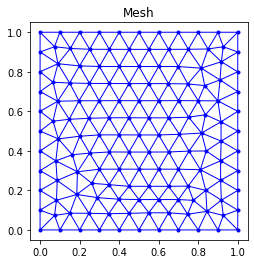

In [16]:
fea=Fea(mesh)
fea.plot_mesh()
# interface
x_fix={}
y_fix={}
f_given={}
for index,position in enumerate(mesh.points):
    x=position[0].tolist()
    y=position[1].tolist()
    if x<1e-6:
        x_fix.update({index:0.0})
        y_fix.update({index:0.0})
    if 1.0-x<1e-6 and abs(y-0.5)<1e-6:
        f_given.update({index:(1.0,0.0)})
fea.set_conditions(x_fix,y_fix,f_given)
fea.submit()

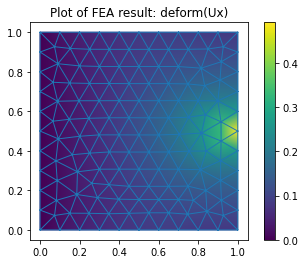

In [17]:
fea.plot('deform','Ux')

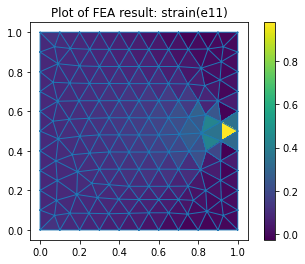

In [18]:
fea.plot('strain','e11')